In [41]:
import mysql.connector as mariadb
import pandas as pd
import pandas.io.sql as psql
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

load_dotenv()

import pdb

### Connect to Database

In [2]:
db=mariadb.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    passwd=os.getenv("DB_PASS"),
    db=os.getenv("DB_NAME"))
query = "select title, date from {}".format(os.getenv("DB_TABLE_NAME"))
forum_titles_frame = psql.read_sql(query, con=db)
db.close()

### Data content and shape

In [3]:
forum_titles_frame.head()

,title,date
0,libro inglés 3 - american english file 2b (sec...,2020-06-05
1,arriendo habitación n club hípico 641 a dos cu...,2020-06-02
2,búsqueda de desarrollador market place - progr...,2020-06-05
3,arriendo pieza metro alcántara,2020-05-31
4,respecto a estudiar al 100% en medio de una pa...,2020-06-02


In [4]:
# pdb.set_trace()
forum_titles_frame.shape

(91986, 2)

In [7]:
forum_titles_frame.index

RangeIndex(start=0, stop=91986, step=1)

### Threads count per year

In [8]:
forum_titles_frame[['date']] = forum_titles_frame[['date']].apply(lambda dateFrame: dateFrame.dt.year)
forum_titles_frame.groupby(['date']).count().loc[2011]

In [ ]:
count_titles = forum_titles_frame.groupby(['date']).count()
count_titles.index

In [24]:
selected_years_mask = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
#count_titles.loc[(count_titles.index > 2008) & (count_titles.index < 2020)]
count_titles.columns = ['thread_count']
count_titles.index.name = 'year'
count_titles.loc[count_titles.index * selected_years_mask > 0]

,thread_count
year,
2009,9874
2010,11322
2011,15503
2012,11256
2013,8834
2014,6194
2015,6484
2016,5652
2017,5386


### Word clouds: total and yearly

In [36]:
mergedTitles = " ".join(forum_titles_frame["title"])
mergedTitles[0:200]

'libro inglés 3 - american english file 2b (second edition) arriendo habitación n club hípico 641 a dos cuadras de beaucheff búsqueda de desarrollador market place - programador arriendo pieza metro al'

#### Stopwords

In [45]:
stopwords_es = np.genfromtxt('stopwords_es.txt', dtype='str')
stopwords_es = formatear(pd.Series(stopwords_es))
stopwords_es = set(map(lambda x: x, stopwords_es))

#### Total word cloud

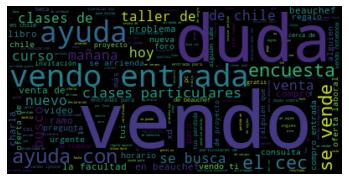

In [46]:
wordcloud = WordCloud(stopwords=stopwords_es).generate(mergedTitles)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Yearly word clouds

In [39]:
def formatear(strings):
    tildes = ['á','é','í','ó','ú']
    vocales = ['a','e','i','o','u']

    # tildes
    for idx, vocal in enumerate(vocales):
        strings = strings.str.replace(tildes[idx],vocal)

    # caracteres especiales menos la ñ
    strings = strings.str.replace('[^a-zñA-Z ]', "")

    # todo a minusculas
    strings = pd.Series(list(map(lambda x: x.lower(), strings)))
    
    return strings